# Overview
Steps to build the network:

1. Load the training data and do a train/validation split.
2. Preprocess data.
3. Build a convolutional neural network to classify traffic signs.
4. Build a feedforward neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json

Using TensorFlow backend.


Load the Data

In [2]:
# Load the data by reading the logfile

data = pd.read_csv('data/data/driving_log.csv',dtype={'center': str, 'left':str,'right':str,'steering': np.float32,'throttle': np.float32,'brake': np.float32,'speed': np.float32})
                   #converters={'category',"Price":int} dtype='category')
print(data.dtypes)

X_train = data['center']
y_train = data['steering']
steering = data['steering']
throttle = data['throttle']
speed=data['speed']
brake=data['brake']
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Training throttle size = ',len(throttle))
print('Training speed size = ',len(speed))

print('Data loaded')

center       object
left         object
right        object
steering    float32
throttle    float32
brake       float32
speed       float32
dtype: object
Training data size =  8036
Training labels size =  8036
Training throttle size =  8036
Training speed size =  8036
Data loaded


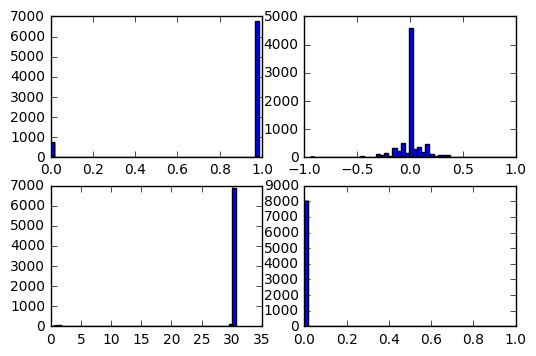

1.0
0.985533


In [3]:
# examine the data
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
plt.hist(throttle,50)
ax = fig.add_subplot(2,2,2)
plt.hist(steering,50)
ax = fig.add_subplot(2,2,3)
plt.hist(speed,50)
ax = fig.add_subplot(2,2,4)
plt.hist(brake,50)
plt.show()
print(max(brake))
print(max(throttle))

In [4]:
# After briefly examining the data I decided to:
# Remove data when steering equals 0
# Remove data when throttle < 0.1 
# Remove data when speed < 25
# Remove data when brake > 0
X_removed = []
y_removed = []
X_remaining = []
y_remaining = []
for i in range(len(X_train)):
    if throttle[i] < 0.5 or speed[i] < 25 or brake[i] > 0 or (steering[i]>-0.01 and steering[i]<0.01):
        X_removed.append(X_train[i])
        y_removed.append(y_train[i])
    else:
        X_remaining.append(X_train[i])
        y_remaining.append(y_train[i])
X_train = X_remaining
y_train = y_remaining
#print('Removed all values with steering = 0.0')
print('Data filtered according to definitions')

Data filtered according to definitions


# there are a lot of images corresponding to the zero value
# we can remove most of them
# 1) copy those values to the zero_values array
# 2) copy the non zero values to the train_crop array
# 3) add just a few random zero values to the final array
X_removed = []
y_removed = []
X_remaining = []
y_remaining = []
for i in range(len(X_train)):
    if y_train[i] == 0:
        X_removed.append(X_train[i])
        y_removed.append(y_train[i])
    else:
        X_remaining.append(X_train[i])
        y_remaining.append(y_train[i])
X_train = X_remaining
y_train = y_remaining
print('Removed all values with steering = 0.0')

Number of elements removed: 4777
Number of elements removed: 4777
Number of elements remaining: 3259
Number of elements remaining: 3259


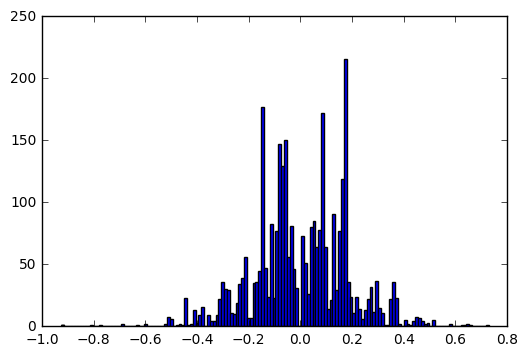

In [5]:
def print_num_el():
    print ('Number of elements removed:',len(X_removed))
    print ('Number of elements removed:',len(y_removed))
    print ('Number of elements remaining:',len(X_train))
    print ('Number of elements remaining:',len(y_train))
print_num_el()
plt.hist(y_train,150)
plt.show()

Higher steering values are very scarce so we need to augment the density of those values in our training set.
In order to do so without interfering with the data directly (e.g. by introducing shifts and artificial rotations, flips, etc) we will just add more of those elements with higher steering by duplicating them.

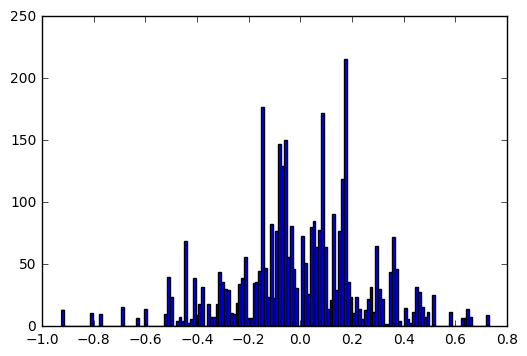

In [6]:
X_train_aug = list(X_train)
y_train_aug = list(y_train)
for i in range(len(y_train)):
#   if abs(y_train_crop[i]) > 0.1:
#        X_train_aug.append(X_train_crop[i])
#        y_train_aug.append(y_train_crop[i])
#    if abs(y_train_crop[i]) > 0.2:
#        X_train_aug.append(X_train_crop[i])
#        y_train_aug.append(y_train_crop[i])
    if abs(y_train[i]) > 0.3:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.4:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.45:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.5:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.55:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.6:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.65:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.7:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.75:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.8:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.85:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.9:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    
plt.hist(y_train_aug, 150)
plt.show()


In [7]:
# there are still a lot of images between -0.2 and 0.2
# we can remove most of them
# 1) copy those values to the zero_values array
# 2) copy the non zero values to the train_crop array
# 3) add just a few random zero values to the final array
X_removed = []
y_removed = []
X_remaining = []
y_remaining = []
for i in range(len(X_train_aug)):
    if y_train_aug[i] > -0.3 and y_train_aug[i] < 0.3:
        X_removed.append(X_train_aug[i])
        y_removed.append(y_train_aug[i])
    else:
        X_remaining.append(X_train_aug[i])
        y_remaining.append(y_train_aug[i])
print('Removed all values with steering between -0.2 and 0.2')

Removed all values with steering between -0.2 and 0.2


In [8]:
print ('Removed:',len(y_removed))
print ('Remaining:',len(y_remaining))

Removed: 2928
Remaining: 925


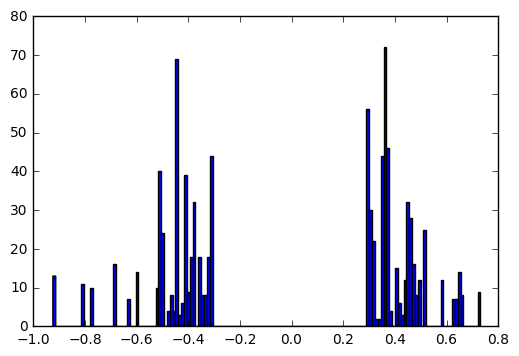

In [9]:
# examine data again
plt.hist(y_remaining,150)
plt.show()

In [10]:
#add some random values back
import random
batch_size = 200
index = np.random.choice(len(y_removed), size=batch_size, replace=False)

for i in index:
    X_remaining.append(X_removed[i])
    y_remaining.append(y_removed[i])
print('Added back some values with steering between -0.2 and 0.2')

Added back some values with steering between -0.2 and 0.2


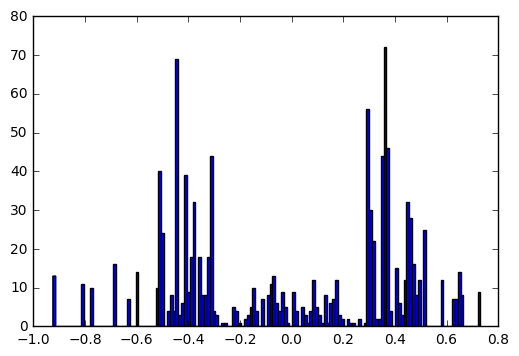

In [11]:
# examine data again
plt.hist(y_remaining,150)
plt.show()

# preprocess all data and save to pickle files
from PIL import Image
import pickle
    
def normalise(im):
    width,height = im.size
    im = np.array(im.resize((round(width*0.5),round(height*0.5)), Image.ANTIALIAS)) # reduce to half size
    im = im/255 - 0.5 # normalise data
    return im
        
def append_pickle (pickle_filename, data):
    with open(pickle_filename,'ab') as wfp:
        pickle.dump(data, wfp)

def process_images (data, pickle_filename):
    X_train_im = []
    for filename in data:
        #print('data/data/'+filename)
        im = Image.open('data/data/'+filename)
        #plt.imshow(im);
        #plt.show()
        im = normalise(im)
        X_train_im.append(im)
    return X_train_im
        #append_pickle(pickle_filename, im)
    #print('Data saved to pickle file:',pickle_filename)
    
def process_labels (data, pickle_filename):
    append_pickle(pickle_filename, data)
    print('Data saved to pickle file:',pickle_filename)

X_train_im = process_images (X_train_crop2,'data.p') # note: here images are saved one by one
#process_labels (y_train[1:6],'labels.p') # note: labels are saved all in one go
print ('Images processed and stored in array')

from numpy import *
print(type(X_train_im))
X_train_im = np.array(X_train_im)
X_train_im =X_train_im.astype(float32)
print(type(X_train_im))
print(type(y_train_crop))
y_train_crop2 = np.array(y_train_crop2)
y_train_crop2 = y_train_crop2.astype(float32)
print(type(y_train_crop))

#save data to pickle files
pickle_filename = 'data.p'
with open(pickle_filename,'wb') as wfp:
    pickle.dump(X_train_im, wfp)
print('data saved to pickle file')
pickle_filename = 'labels.p'
with open(pickle_filename,'wb') as wfp:
    pickle.dump(y_train_crop2, wfp)
print('labels saved to pickle file')

import pickle
# read data from pickle files

with open('data.p','rb') as rfp:
    data = pickle.load(rfp)
y_train = []
with open('labels.p','rb') as rfp:
    labels = pickle.load(rfp)
print(len(data))
print(len(labels))

In [12]:
data = X_remaining
labels = y_remaining
print(len(X_remaining))
print(len(y_remaining))

1125
1125


In [13]:
from sklearn.model_selection import train_test_split

# split data into train, validate and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2,random_state=42)
#print(X_train.shape[0])
print('Data splitted into train, validation anda test data')
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Validation data size = ',len(X_val))
print('Validation labels size = ',len(y_val))
print('Test data size = ',len(X_test))
print('Test labels size = ',len(y_test))

Data splitted into train, validation anda test data
Training data size =  787
Training labels size =  787
Validation data size =  270
Validation labels size =  270
Test data size =  68
Test labels size =  68


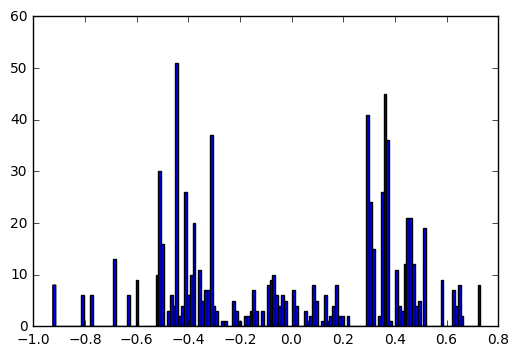

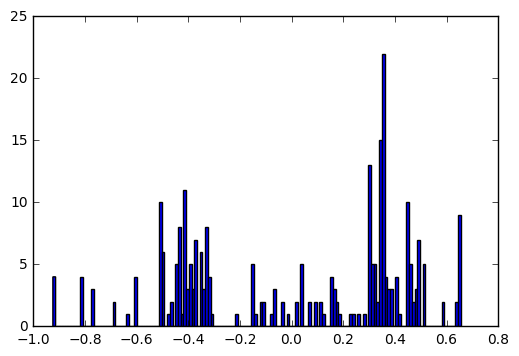

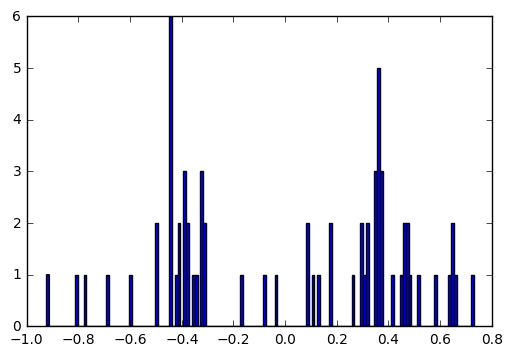

In [14]:
plt.hist(y_train,150)
plt.show()
plt.hist(y_val,150)
plt.show()
plt.hist(y_test,150)
plt.show()

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
# define the model
#print('Input shape:',(X_train[0].shape))
#height,width,depth = X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]
#print('Input size:',height,',',width,',',depth)
#subsample=strides
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(160, 320, 3),output_shape=(160, 320, 3)))
model.add(Conv2D(24, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization()) #normalisation should be done before activation
model.add(Activation('relu'))
model.add(Conv2D(36, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(48, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
#model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(100, name='fc1'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
#model.add(Dropout(0.2))
model.add(Dense(50, name='fc2'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
#model.add(Dense(10, name='fc3'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,name='output'))

# other layers we may add
#model.add(MaxPooling2D((2,2)))

#Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
#keras.layers.normalization.BatchNormalization(epsilon=0.001, mode=0, axis=-1, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)

# for a mean squared error regression problem
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')
#model.compile(optimizer='rmsprop',loss='mse')
model.summary()
print('Model defined')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 78, 158, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 78, 158, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 37, 77, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

def next_batch(first_array, second_array, batch_size):
    index = np.random.choice(len(first_array), size=batch_size, replace=False)
    result_x = []
    result_y = []
    for id in index:
        result_x.append(first_array[id])
        result_y.append(second_array[id])
    return result_x, result_y

print('next_batch defined as a data generator')

def next_batch_val(first_array, second_array, batch_size):
    index = np.random.choice(len(first_array), size=batch_size, replace=False)
    result_x = []
    result_y = []
    for id in index:
        result_x.append(first_array[id])
        result_y.append(second_array[id])
    #result = (result_x, result_y)
    #yield result_x, result_y
    yield result_x, result_y

print('next_batch_val defined as a data generator')

In [16]:
from PIL import Image
    
def generator(X, Y):
    while 1:
        X_sh = []
        Y_sh = []
        index_shuf = list(range(len(Y)))
        random.shuffle(index_shuf)
        for i in index_shuf:
           X_sh.append(X[i])
           Y_sh.append(Y[i])
        for (x, y) in zip(X_sh, Y_sh):
        #for (x, y) in zip(X, Y):
            path, angle = (x, y)
            angle = np.reshape(angle, [1])
            image = Image.open('./data/data/' + path)
            image_array = np.asarray(image)
            transformed_image_array = image_array[None, :, :, :]
            #image = cv2.imread('./data/data/' + path)
            #image = np.reshape(image, (1, 160, 320, 3))
            yield transformed_image_array, angle

IMG/center_2016_12_01_13_45_42_584.jpg


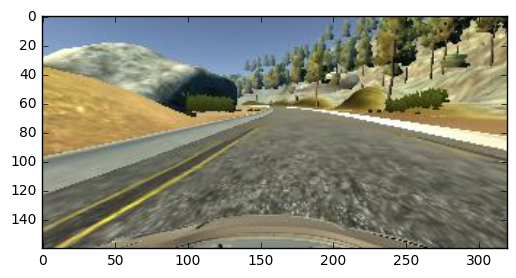

In [17]:
print(X_train[0])
#image = cv2.imread('./data/data/' + X_train[0])
image = Image.open('./data/data/' + X_train[0])
image_array = np.asarray(image)
plt.imshow(image)
plt.show()

In [18]:
#train the model
from keras.callbacks import ModelCheckpoint
print('')
iterations = 50
train_batch_size = 200#len(y_val) # len(X_train)
val_batch_size = 200#len(y_val)   # len(y_val)  #1928 
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, monitor = 'val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(generator(X_train, y_train), 
                    samples_per_epoch= train_batch_size,
                    nb_epoch=iterations,
                    callbacks=callbacks_list,
                    verbose=1,
                    validation_data=generator(X_val, y_val),
                    nb_val_samples=val_batch_size)
#history = model.fit(X_train, y_train, batch_size=train_batch_size, nb_epoch=iterations, callbacks=callbacks_list, verbose=1, validation_data=(X_val, y_val))
#history = model.fit_generator(next_batch(X_train,y_train,train_batch_size), samples_per_epoch=5000, nb_epoch=iterations,
  #                 verbose=1, validation_data=next_batch_val(X_val,y_val,val_batch_size), nb_val_samples=1000)
print('----------------- Model trained! -----------------')


Epoch 1/50
100/100 [==============================] - 7s - loss: 0.2940 - val_loss: 0.1381
Epoch 2/50
100/100 [==============================] - 6s - loss: 0.1994 - val_loss: 0.0943
Epoch 3/50
100/100 [==============================] - 6s - loss: 0.1758 - val_loss: 0.0772
Epoch 4/50
100/100 [==============================] - 6s - loss: 0.1637 - val_loss: 0.0575
Epoch 5/50
100/100 [==============================] - 6s - loss: 0.1454 - val_loss: 0.0543
Epoch 6/50
100/100 [==============================] - 6s - loss: 0.1319 - val_loss: 0.0375
Epoch 7/50
100/100 [==============================] - 6s - loss: 0.1286 - val_loss: 0.0447
Epoch 8/50
100/100 [==============================] - 6s - loss: 0.1234 - val_loss: 0.0508
Epoch 9/50
100/100 [==============================] - 6s - loss: 0.1083 - val_loss: 0.0422
Epoch 10/50
100/100 [==============================] - 6s - loss: 0.1080 - val_loss: 0.0375
Epoch 11/50
100/100 [==============================] - 6s - loss: 0.1050 - val_loss: 0.0

In [19]:
# evaluate the model
scores = model.evaluate_generator(generator(X_test, y_test),len(X_test))
print(scores)

0.0146993279578


In [20]:
from keras.models import model_from_json
import json

# convert model to json format
json_string = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

#save model to files
model.save_weights('model.h5')

print('Model saved to file.')

Model saved to file.


In [71]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('model.h5')